<a href="https://colab.research.google.com/github/JinXianWen95/PyTorch-bootcamp/blob/main/PyTorch_2_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch 2.0 Intro

In [1]:
import torch
import torchvision

## Quick code examples

### Before PyTorch 2.0

In [2]:
model = torchvision.models.resnet50() # note: this could be any model

### After PyTorch 2.0

In [3]:
model = torchvision.models.resnet50() # note: this could be any model
compiled_model = torch.compile(model)

## 1. Get GPU info

PyTorch 2.0 features work best on newer NVIDIA GPU.

To find out if the GPU is compatible, check NVIDIA GPU compability scores - https://developer.nvidia.com/cuda/gpus

If your GPU has a score of 8+, it can leverage *most* of the new PyTorch 2.0 features.

GPU under 8.0 can still leverage PyTorch 2.0, however the improvement may not be visible.



In [14]:
# Make sure we're using a NVIDIA GPU
if torch.cuda.is_available():
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find("failed") >= 0:
    print("Not connected to a GPU, to leverage the best of PyTorch 2.0, you should connect to a GPU.")

  # Get GPU name
  gpu_name = !nvidia-smi --query-gpu=gpu_name --format=csv
  gpu_name = gpu_name[1]
  GPU_NAME = gpu_name.replace(" ", "_") # remove underscores for easier saving
  print(f'GPU name: {GPU_NAME}')

  # Get GPU capability score
  GPU_SCORE = torch.cuda.get_device_capability()
  print(f"GPU capability score: {GPU_SCORE}")
  if GPU_SCORE >= (8, 0):
    print(f"GPU score higher than or equal to (8, 0), PyTorch 2.x speedup features available.")
  else:
    print(f"GPU score lower than (8, 0), PyTorch 2.x speedup features will be limited (PyTorch 2.x speedups happen most on newer GPUs).")

  # Print GPU info
  print(f"GPU information:\n{gpu_info}")

else:
  print("PyTorch couldn't find a GPU, to leverage the best of PyTorch 2.0, you should connect to a GPU.")

GPU name: Tesla_T4
GPU capability score: (7, 5)
GPU score lower than (8, 0), PyTorch 2.x speedup features will be limited (PyTorch 2.x speedups happen most on newer GPUs).
GPU information:
Thu Feb 26 18:52:34 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   61C    P0             30W /   70W |

### 1.1 Globally set devices

In [4]:
import torch

# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Set the device globally
torch.set_default_device(device)

# All tensors created will be on the global device by default
layer = torch.nn.Linear(20, 30)
print(f"Layer weights are on device: {layer.weight.device}")
print(f"Layer creating data on device: {layer(torch.randn(128, 20)).device}")

Layer weights are on device: cuda:0
Layer creating data on device: cuda:0


In [5]:
# Set the device globally
torch.set_default_device("cpu")

# All tensors created will be on "cpu"
layer = torch.nn.Linear(20, 30)
print(f"Layer weights are on device: {layer.weight.device}")
print(f"Layer creating data on device: {layer(torch.randn(128, 20)).device}")

Layer weights are on device: cpu
Layer creating data on device: cpu


## 2. Setting up the experiments

We'll run 4 experiments:
* Model: ResNet50 from torchvision
* Data: CIFAR10 from TorchVision
* Epochs: 5 (single run) and 3x5 (multiple runs)
* Batch size: 128 (note: this depends on the amount of the memory of the GPU has)
* Image size: 224 (same as above)

Each experiment will be run with and without torch.compile().

In [6]:
import torch
import torchvision

print(f"PyTorch version: {torch.__version__}")
print(f"TorchVision version: {torchvision.__version__}")

# Set the target device
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")

PyTorch version: 2.10.0+cu128
TorchVision version: 0.25.0+cu128
Using device: cuda


### 2.1 Create model and transforms

* ResNet50

In [7]:
# Create model weights and transforms
model_weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2 # <- use the latest weights (could also use .DEFAULT)
resnet_transforms = model_weights.transforms()

# Setup model
model = torchvision.models.resnet50(weights=model_weights)

# Count the number of parameters in the model
total_params = sum(
    param.numel() for param in model.parameters() # <- all params
	# param.numel() for param in model.parameters() if param.requires_grad # <- only trainable params
)

print(f"Total parameters of model: {total_params} (the more parameters, the more GPU memory the model will use, the more *relative* of a speedup you'll get)")
print(f"Model transforms:\n{resnet_transforms}")
print(model)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:02<00:00, 48.7MB/s]


Total parameters of model: 25557032 (the more parameters, the more GPU memory the model will use, the more *relative* of a speedup you'll get)
Model transforms:
ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

In [9]:
def create_model(num_classes=10):
  """
  Creates a ResNet50 model with the latest weights and transforms via torchvision.
  """
  model_weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2
  resnet_transforms = model_weights.transforms()
  model = torchvision.models.resnet50(weights=model_weights)

  # Adjust the number of output features in model to match the number of classes in the dataset
  model.fc = torch.nn.Linear(in_features=2048,
                             out_features=num_classes)
  return model, resnet_transforms

model, resnet_transforms = create_model()

### 2.2 Speedups are most noticeable when a large portion of the GPU is being used

Since modern GPUs are so *fast* at performing operations, you will often notice the majority of *relative* speedups when as much data as possible is on the GPU.

This can be achieved by:

* Increasing the batch size - More samples per batch means more samples on the GPU, for example, using a batch size of 256 instead of 32.
* Increasing data size - For example, using larger image size, 224x224 instead of 32x32. A larger data size means that more tensor operations will be happening on the GPU.
* Increasing model size - For example, using a larger model such as ResNet101 instead of ResNet50. A larger model means that more tensor operations will be happening on the GPU.
* Decreasing data transfer - For example, setting up all your tensors to be on GPU memory, this minimizes the amount of data transfer between the CPU and GPU.

As a result of doing the above, the relative speedups should be better.

E.g. overall training time may take longer but not linearly.

**Note:** This concept of using as much data on the GPU as possible isn't restricted to PyTorch 2.0, it apllies to all models that train on GPUs.

### 2.3. Checking the memory limits of GPU

In [10]:
# Check available GPU memory and total GPU memory
total_free_gpu_memory, total_gpu_memory = torch.cuda.mem_get_info()
print(f"Total free GPU memory: {round(total_free_gpu_memory * 1e-9, 3)} GB")
print(f"Total GPU memory: {round(total_gpu_memory * 1e-9, 3)} GB")

Total free GPU memory: 15.491 GB
Total GPU memory: 15.637 GB


* If the GPU has 16GB+ of free memory, set batch size to 128
* Otherwise set batch size to 32

In [11]:
# Set batch size depending on amount of GPU memory
total_free_gpu_memory_gb = round(total_free_gpu_memory * 1e-9, 3)
if total_free_gpu_memory_gb >= 16:
  BATCH_SIZE = 128 # Note: you could experiment with higher values here if you like.
  IMAGE_SIZE = 224
  print(f"GPU memory available is {total_free_gpu_memory_gb} GB, using batch size of {BATCH_SIZE} and image size {IMAGE_SIZE}")
else:
  BATCH_SIZE = 32
  IMAGE_SIZE = 128
  print(f"GPU memory available is {total_free_gpu_memory_gb} GB, using batch size of {BATCH_SIZE} and image size {IMAGE_SIZE}")

GPU memory available is 15.491 GB, using batch size of 32 and image size 128


In [12]:
resnet_transforms.crop_size = IMAGE_SIZE
resnet_transforms.resize_size = IMAGE_SIZE
print(f"Updated data transforms:\n{resnet_transforms}")

Updated data transforms:
ImageClassification(
    crop_size=128
    resize_size=128
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


### 2.4 More potential speedups with TF32

TF32 = TensorFloat32

What we want is:
1. Fast model training
2. Accurate model training

TensorFloat32 = a datatype from NVDIA which combines float32 (accuracy) and float16 (speed).

TF32 is available on Ampere GPU+

In [15]:
if GPU_SCORE >= (8, 0):
  print(f"[INFO] Using GPU with score: {GPU_SCORE}, enabling TensorFloat32 (TF32) computing (faster on new GPUs)")
  torch.backends.cuda.matmul.allow_tf32 = True
else:
  print(f"[INFO] Using GPU with score: {GPU_SCORE}, TensorFloat32 (TF32) not available, to use it you need a GPU with score >= (8, 0)")
  torch.backends.cuda.matmul.allow_tf32 = False

[INFO] Using GPU with score: (7, 5), TensorFloat32 (TF32) not available, to use it you need a GPU with score >= (8, 0)


### 2.5 Get data

In [16]:
import os
import shutil
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from google.colab import drive, userdata

# 1. MOUNT GOOGLE DRIVE
drive.mount('/content/drive')

# 2. DEFINE PATHS
# Persistent storage on your Drive
drive_base_path = "/content/drive/MyDrive/colab_copilot_data/data"
drive_zip_path = os.path.join(drive_base_path, "cifar-10-python.tar.gz")

# High-speed local storage on Colab's NVMe
local_data_dir = "/content/data"
local_zip_path = "/content/cifar-10-python.tar.gz"

# 3. PERMANENT STORAGE CHECK (One-time download to Drive)
if not os.path.exists(drive_zip_path):
    print("🚀 Initial setup: Downloading cifar-10-python to your Google Drive...")
    os.makedirs(drive_base_path, exist_ok=True)
    # This downloads to Drive via Google's backbone (no local data used)
    datasets.CIFAR10(root=drive_base_path, train=True, download=True)
    datasets.CIFAR10(root=drive_base_path, train=False, download=True)
else:
    print("✅ Dataset found in Google Drive.")

# 4. FAST LOCAL COPY (Internal Google transfer - 0% internet data)
if not os.path.exists(local_data_dir):
    print("📦 Moving archive to local high-speed disk...")
    shutil.copy(drive_zip_path, local_zip_path)

    print("🏗️ Extracting locally...")
    os.makedirs(local_data_dir, exist_ok=True)
    !tar -xzf {local_zip_path} -C {local_data_dir}

    # Clean up the local zip to free up space
    os.remove(local_zip_path)
    print("🚀 Data is now local and ready for fast training!")

# 6. CREATE DATASETS (Point to LOCAL path)
train_dataset = datasets.CIFAR10(root=local_data_dir,
                              train=True,
                              transform=resnet_transforms,
                              download=False)

test_dataset = datasets.CIFAR10(root=local_data_dir,
                             train=False,
                             transform=resnet_transforms,
                             download=False)

# Get the lengths of the datasets
train_len = len(train_dataset)
test_len = len(test_dataset)

print(f"[INFO] Train dataset length: {train_len}")
print(f"[INFO] Test dataset length: {test_len}")

from torch.utils.data import DataLoader

# Create DataLoaders
NUM_WORKERS = os.cpu_count() # <- use all available CPU cores (this number can be tweaked through experimentation but generally more workers means faster dataloading from CPU to GPU)

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=0)

test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=0)

# Print details
print(f"Train dataloader length: {len(train_dataloader)} batches of size {BATCH_SIZE}")
print(f"Test dataloader length: {len(test_dataloader)} batches of size {BATCH_SIZE}")
print(f"Using number of workers: {NUM_WORKERS} (generally more workers means faster dataloading from CPU to GPU)")

Mounted at /content/drive
✅ Dataset found in Google Drive.
📦 Moving archive to local high-speed disk...
🏗️ Extracting locally...
🚀 Data is now local and ready for fast training!
[INFO] Train dataset length: 50000
[INFO] Test dataset length: 10000
Train dataloader length: 1563 batches of size 32
Test dataloader length: 313 batches of size 32
Using number of workers: 2 (generally more workers means faster dataloading from CPU to GPU)


### 2.6 Creating training and testing loops

In [17]:
import time
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(epoch: int,
               model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device,
               disable_progress_bar: bool = False) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  progress_bar = tqdm(
        enumerate(dataloader),
        desc=f"Training Epoch {epoch}",
        total=len(dataloader),
        disable=disable_progress_bar
    )

  for batch, (X, y) in progress_bar:
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metrics across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

      # Update progress bar
      progress_bar.set_postfix(
            {
                "train_loss": train_loss / (batch + 1),
                "train_acc": train_acc / (batch + 1),
            }
        )


  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(epoch: int,
              model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device,
              disable_progress_bar: bool = False) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Loop through data loader data batches
  progress_bar = tqdm(
      enumerate(dataloader),
      desc=f"Testing Epoch {epoch}",
      total=len(dataloader),
      disable=disable_progress_bar
  )

  # Turn on inference context manager
  with torch.no_grad(): # no_grad() required for PyTorch 2.0, I found some errors with `torch.inference_mode()`
      # Loop through DataLoader batches
      for batch, (X, y) in progress_bar:
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

          # Update progress bar
          progress_bar.set_postfix(
              {
                  "test_loss": test_loss / (batch + 1),
                  "test_acc": test_acc / (batch + 1),
              }
          )

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          disable_progress_bar: bool = False) -> Dict[str, List]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]}
    For example if training for epochs=2:
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]}
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": [],
      "train_epoch_time": [],
      "test_epoch_time": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs), disable=disable_progress_bar):

      # Perform training step and time it
      train_epoch_start_time = time.time()
      train_loss, train_acc = train_step(epoch=epoch,
                                        model=model,
                                        dataloader=train_dataloader,
                                        loss_fn=loss_fn,
                                        optimizer=optimizer,
                                        device=device,
                                        disable_progress_bar=disable_progress_bar)
      train_epoch_end_time = time.time()
      train_epoch_time = train_epoch_end_time - train_epoch_start_time

      # Perform testing step and time it
      test_epoch_start_time = time.time()
      test_loss, test_acc = test_step(epoch=epoch,
                                      model=model,
                                      dataloader=test_dataloader,
                                      loss_fn=loss_fn,
                                      device=device,
                                      disable_progress_bar=disable_progress_bar)
      test_epoch_end_time = time.time()
      test_epoch_time = test_epoch_end_time - test_epoch_start_time

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f} | "
          f"train_epoch_time: {train_epoch_time:.4f} | "
          f"test_epoch_time: {test_epoch_time:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)
      results["train_epoch_time"].append(train_epoch_time)
      results["test_epoch_time"].append(test_epoch_time)

  # Return the filled results at the end of the epochs
  return results

## 3. Time models across a single run



### 3.1 Experiment 1 - Single run, no compile
Experiment 1: single run without `torch.compile()` for 5 epochs

In [19]:
NUM_EPOCHS = 5
LEARNING_RATE = 0.003

In [20]:
# torch.set_default_device(device)

# Create model
model, transforms = create_model()

# Create loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

# Train model and track results
single_run_no_compile_results = train(model=model.to(device),
                                      train_dataloader=train_dataloader,
                                      test_dataloader=test_dataloader,
                                      loss_fn=loss_fn,
                                      optimizer=optimizer,
                                      epochs=NUM_EPOCHS,
                                      device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1472 | train_acc: 0.5892 | test_loss: 0.9225 | test_acc: 0.6796 | train_epoch_time: 228.7257 | test_epoch_time: 19.5532


Training Epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.6924 | train_acc: 0.7595 | test_loss: 0.6181 | test_acc: 0.7851 | train_epoch_time: 227.8560 | test_epoch_time: 20.2354


Training Epoch 2:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.5254 | train_acc: 0.8182 | test_loss: 0.5797 | test_acc: 0.7996 | train_epoch_time: 227.2273 | test_epoch_time: 19.4846


Training Epoch 3:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.4175 | train_acc: 0.8547 | test_loss: 0.5551 | test_acc: 0.8184 | train_epoch_time: 227.6334 | test_epoch_time: 20.2959


Training Epoch 4:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.3273 | train_acc: 0.8861 | test_loss: 0.4673 | test_acc: 0.8410 | train_epoch_time: 227.4196 | test_epoch_time: 19.8737


### 3.2 Experiment 2 -Single run, compile

In [21]:
# Create model
model, transforms = create_model()

# Create loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

# Compile the model and time how long it takes
compile_start_time = time.time()
compiled_model = torch.compile(model)
compile_end_time = time.time()

compile_time = compile_end_time - compile_start_time
print(f"Time to compile: {compile_time} | Note: The first time you compile your model, the first few epochs will be slower than subsequent runs.")


# Train model and track results
single_run_compile_results = train(model=compiled_model.to(device),
                                      train_dataloader=train_dataloader,
                                      test_dataloader=test_dataloader,
                                      loss_fn=loss_fn,
                                      optimizer=optimizer,
                                      epochs=NUM_EPOCHS,
                                      device=device)

Time to compile: 0.006524324417114258 | Note: The first time you compile your model, the first few epochs will be slower than subsequent runs.


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/1563 [00:00<?, ?it/s]

W0226 19:15:07.908000 447 torch/_inductor/utils.py:1679] [0/0] Not enough SMs to use max_autotune_gemm mode


Testing Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1643 | train_acc: 0.5843 | test_loss: 0.9029 | test_acc: 0.6753 | train_epoch_time: 383.6135 | test_epoch_time: 35.3315


Training Epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.7141 | train_acc: 0.7501 | test_loss: 0.6917 | test_acc: 0.7606 | train_epoch_time: 212.0968 | test_epoch_time: 18.5459


Training Epoch 2:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.5415 | train_acc: 0.8116 | test_loss: 0.5537 | test_acc: 0.8060 | train_epoch_time: 211.5957 | test_epoch_time: 18.1626


Training Epoch 3:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.4211 | train_acc: 0.8541 | test_loss: 0.4994 | test_acc: 0.8304 | train_epoch_time: 212.9425 | test_epoch_time: 18.0565


Training Epoch 4:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.3253 | train_acc: 0.8867 | test_loss: 0.5097 | test_acc: 0.8299 | train_epoch_time: 213.2191 | test_epoch_time: 19.4029


### 3.3 Compare the results of experiment 1 and 2

In [22]:
# Turn experiment results into dataframes
import pandas as pd
single_run_no_compile_results_df = pd.DataFrame(single_run_no_compile_results)
single_run_compile_results_df = pd.DataFrame(single_run_compile_results)

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Create filename to save the results
DATASET_NAME = "CIFAR10"
MODEL_NAME = "ResNet50"

def plot_mean_epoch_times(non_compiled_results: pd.DataFrame,
                          compiled_results: pd.DataFrame,
                          multi_runs: bool=False,
                          num_runs: int=0,
                          save: bool=False,
                          save_path: str="",
                          dataset_name: str=DATASET_NAME,
                          model_name: str=MODEL_NAME,
                          num_epochs: int=NUM_EPOCHS,
                          image_size: int=IMAGE_SIZE,
                          batch_size: int=BATCH_SIZE) -> plt.figure:

    # Get the mean epoch times from the non-compiled models
    mean_train_epoch_time = non_compiled_results.train_epoch_time.mean()
    mean_test_epoch_time = non_compiled_results.test_epoch_time.mean()
    mean_results = [mean_train_epoch_time, mean_test_epoch_time]

    # Get the mean epoch times from the compiled models
    mean_compile_train_epoch_time = compiled_results.train_epoch_time.mean()
    mean_compile_test_epoch_time = compiled_results.test_epoch_time.mean()
    mean_compile_results = [mean_compile_train_epoch_time, mean_compile_test_epoch_time]

    # Calculate the percentage difference between the mean compile and non-compile train epoch times
    train_epoch_time_diff = mean_compile_train_epoch_time - mean_train_epoch_time
    train_epoch_time_diff_percent = (train_epoch_time_diff / mean_train_epoch_time) * 100

    # Calculate the percentage difference between the mean compile and non-compile test epoch times
    test_epoch_time_diff = mean_compile_test_epoch_time - mean_test_epoch_time
    test_epoch_time_diff_percent = (test_epoch_time_diff / mean_test_epoch_time) * 100

    # Print the mean difference percentages
    print(f"Mean train epoch time difference: {round(train_epoch_time_diff_percent, 3)}% (negative means faster)")
    print(f"Mean test epoch time difference: {round(test_epoch_time_diff_percent, 3)}% (negative means faster)")

    # Create a bar plot of the mean train and test epoch time for both compiled and non-compiled models
    plt.figure(figsize=(10, 7))
    width = 0.3
    x_indicies = np.arange(len(mean_results))

    plt.bar(x=x_indicies, height=mean_results, width=width, label="non_compiled_results")
    plt.bar(x=x_indicies + width, height=mean_compile_results, width=width, label="compiled_results")
    plt.xticks(x_indicies + width / 2, ("Train Epoch", "Test Epoch"))
    plt.ylabel("Mean epoch time (seconds, lower is better)")

    # Create the title based on the parameters passed to the function
    if multi_runs:
        plt.suptitle("Multiple run results")
        plt.title(f"GPU: {gpu_name} | Epochs: {num_epochs} ({num_runs} runs) | Data: {dataset_name} | Model: {model_name} | Image size: {image_size} | Batch size: {batch_size}")
    else:
        plt.suptitle("Single run results")
        plt.title(f"GPU: {gpu_name} | Epochs: {num_epochs} | Data: {dataset_name} | Model: {model_name} | Image size: {image_size} | Batch size: {batch_size}")
    plt.legend();

    # Save the figure
    if save:
        assert save_path != "", "Please specify a save path to save the model figure to via the save_path parameter."
        plt.savefig(save_path)
        print(f"[INFO] Plot saved to {save_path}")

[INFO] Save path for single run results: pytorch_2_results/figures/single_run_Tesla_T4_ResNet50_CIFAR10_128_train_epoch_time.png
Mean train epoch time difference: 8.307% (negative means faster)
Mean test epoch time difference: 10.113% (negative means faster)
[INFO] Plot saved to pytorch_2_results/figures/single_run_Tesla_T4_ResNet50_CIFAR10_128_train_epoch_time.png


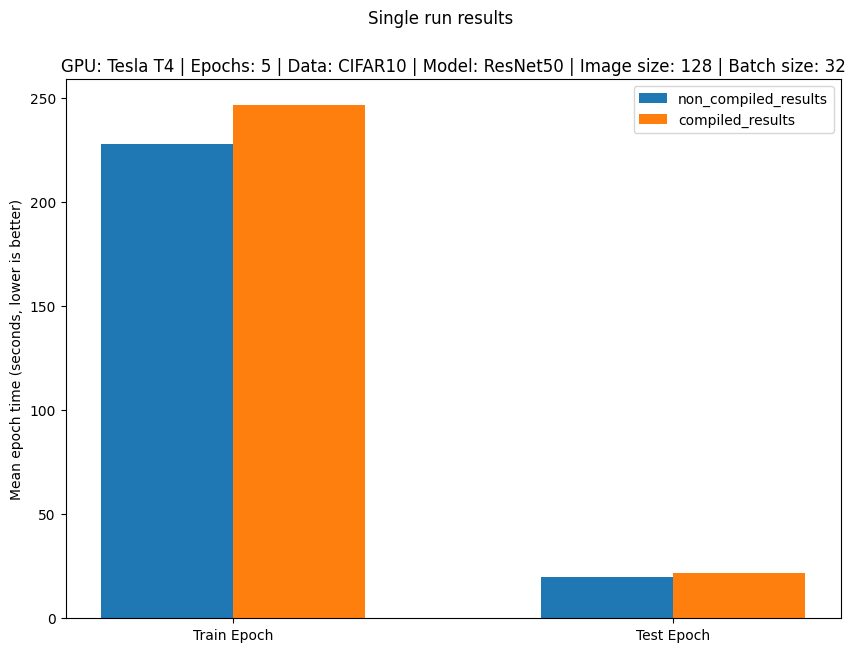

In [24]:
# Create directory for saving figures
import os
dir_to_save_figures_in = "pytorch_2_results/figures/"
os.makedirs(dir_to_save_figures_in, exist_ok=True)

# Create a save path for the single run results
save_path_multi_run = f"{dir_to_save_figures_in}single_run_{GPU_NAME}_{MODEL_NAME}_{DATASET_NAME}_{IMAGE_SIZE}_train_epoch_time.png"
print(f"[INFO] Save path for single run results: {save_path_multi_run}")

# Plot the results and save the figures
plot_mean_epoch_times(non_compiled_results=single_run_no_compile_results_df,
                      compiled_results=single_run_compile_results_df,
                      multi_runs=False,
                      save_path=save_path_multi_run,
                      save=True)

The average training time of compiled model could be higher than the no-compiled one if the epochs are not big enough. This because the first epoch of compiled model takes more for optimization.

### 3.4 Save single run results to a file

In [ ]:
# Make a directory for single_run results
import os
pytorch_2_results_dir = "pytorch_2_results"
pytorch_2_single_run_results_dir = f"{pytorch_2_results_dir}/single_run_results"
os.makedirs(pytorch_2_single_run_results_dir, exist_ok=True)

# Create filenames for each of the dataframes
save_name_for_non_compiled_results = f"single_run_non_compiled_results_{DATASET_NAME}_{MODEL_NAME}_{GPU_NAME}.csv"
save_name_for_compiled_results = f"single_run_compiled_results_{DATASET_NAME}_{MODEL_NAME}_{GPU_NAME}.csv"

# Create filepaths to save the results to
single_run_no_compile_save_path = f"{pytorch_2_single_run_results_dir}/{save_name_for_non_compiled_results}"
single_run_compile_save_path = f"{pytorch_2_single_run_results_dir}/{save_name_for_compiled_results}"
print(f"[INFO] Saving non-compiled experiment 1 results to: {single_run_no_compile_save_path}")
print(f"[INFO] Saving compiled experiment 2 results to: {single_run_compile_save_path}")

# Save the results
single_run_no_compile_results_df.to_csv(single_run_no_compile_save_path)
single_run_compile_results_df.to_csv(single_run_compile_save_path)

[INFO] Saving non-compiled experiment 1 results to: pytorch_2_results/single_run_results/single_run_non_compiled_results_CIFAR10_ResNet50_Tesla_T4.csv
[INFO] Saving compiled experiment 2 results to: pytorch_2_results/single_run_results/single_run_compiled_results_CIFAR10_ResNet50_Tesla_T4.csv


## 4. Time models across multiple runs


In [ ]:
def create_and_train_non_compiled_model(epochs=NUM_EPOCHS,
                                        learning_rate=LEARNING_RATE,
                                        disable_progress_bar=False):
    """
    Create and train a non-compiled PyTorch model.
    """
    model, _ = create_model()
    model.to(device)

    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate)

    results = train(model=model,
                    train_dataloader=train_dataloader,
                    test_dataloader=test_dataloader,
                    loss_fn=loss_fn,
                    optimizer=optimizer,
                    epochs=epochs,
                    device=device,
                    disable_progress_bar=disable_progress_bar)
    return results

def create_compiled_model():
    """
    Create a compiled PyTorch model and return it.
    """
    model, _ = create_model()
    model.to(device)

    compile_start_time = time.time()
    ### New in PyTorch 2.x ###
    compiled_model = torch.compile(model)
    ##########################
    compile_end_time = time.time()

    compile_time = compile_end_time - compile_start_time

    print(f"Time to compile: {compile_time} | Note: The first time you compile your model, the first few epochs will be slower than subsequent runs.")
    return compiled_model

def train_compiled_model(model,
                         epochs=NUM_EPOCHS,
                         learning_rate=LEARNING_RATE,
                         disable_progress_bar=False):
    """
    Train a compiled model and return the results.
    """
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate)

    compile_results = train(model=model,
                            train_dataloader=train_dataloader,
                            test_dataloader=test_dataloader,
                            loss_fn=loss_fn,
                            optimizer=optimizer,
                            epochs=epochs,
                            device=device,
                            disable_progress_bar=disable_progress_bar)

    return compile_results

### 4.1 Experiment 3 - Multiple run, no compile

**Note:** Because we are running multiple runs, the code below may take a while.

In [ ]:
# Run non-compiled model for multiple runs
NUM_RUNS = 3
NUM_EPOCHS = 3

# Create an empty list to store multiple run results
non_compile_results_multiple_runs = []

# Run non-compiled model for multiple runs
for i in tqdm(range(NUM_RUNS)):
    print(f"[INFO] Run {i+1} of {NUM_RUNS} for non-compiled model")
    results = create_and_train_non_compiled_model(epochs=NUM_EPOCHS, disable_progress_bar=True)
    non_compile_results_multiple_runs.append(results)

  0%|          | 0/3 [00:00<?, ?it/s]

[INFO] Run 1 of 3 for non-compiled model
Epoch: 1 | train_loss: 1.0738 | train_acc: 0.6199 | test_loss: 0.9065 | test_acc: 0.6837 | train_epoch_time: 207.4785 | test_epoch_time: 17.0262
Epoch: 2 | train_loss: 0.6424 | train_acc: 0.7771 | test_loss: 0.6050 | test_acc: 0.7937 | train_epoch_time: 207.1124 | test_epoch_time: 16.5610
Epoch: 3 | train_loss: 0.4979 | train_acc: 0.8289 | test_loss: 0.5473 | test_acc: 0.8137 | train_epoch_time: 207.3250 | test_epoch_time: 16.7817
[INFO] Run 2 of 3 for non-compiled model
Epoch: 1 | train_loss: 1.0878 | train_acc: 0.6102 | test_loss: 0.9070 | test_acc: 0.6895 | train_epoch_time: 207.6396 | test_epoch_time: 17.0993
Epoch: 2 | train_loss: 0.6679 | train_acc: 0.7689 | test_loss: 0.6080 | test_acc: 0.7881 | train_epoch_time: 206.8853 | test_epoch_time: 16.7218
Epoch: 3 | train_loss: 0.5122 | train_acc: 0.8221 | test_loss: 0.5334 | test_acc: 0.8178 | train_epoch_time: 207.0712 | test_epoch_time: 16.7762
[INFO] Run 3 of 3 for non-compiled model
Epoch: 

In [ ]:
# Go through non_compile_results_multiple_runs and create a dataframe for each run then concatenate them together
non_compile_results_dfs = []
for result in non_compile_results_multiple_runs:
    result_df = pd.DataFrame(result)
    non_compile_results_dfs.append(result_df)
non_compile_results_multiple_runs_df = pd.concat(non_compile_results_dfs)

# Get the averages across the multiple runs
non_compile_results_multiple_runs_df = non_compile_results_multiple_runs_df.groupby(non_compile_results_multiple_runs_df.index).mean()
non_compile_results_multiple_runs_df

,train_loss,train_acc,test_loss,test_acc,train_epoch_time,test_epoch_time
0,1.101358,0.608032,0.914448,0.680178,207.239813,17.004990
1,0.665394,0.769261,0.624426,0.784711,206.794822,16.573859
2,0.510801,0.823230,0.534118,0.817925,206.738295,16.759761


### 4.2 Experiment 4 - Multiple run, compile

In [ ]:
# Create compiled model
compiled_model = create_compiled_model()

# Create an empty list to store compiled model results
compiled_results_multiple_runs = []

# Run compiled model for multiple runs
for i in tqdm(range(NUM_RUNS)):
    print(f"[INFO] Run {i+1} of {NUM_RUNS} for compiled model")
    # Train the compiled model (note: the model will only be compiled once and then re-used for subsequent runs)
    results = train_compiled_model(model=compiled_model, epochs=NUM_EPOCHS, disable_progress_bar=True)
    compiled_results_multiple_runs.append(results)

Time to compile: 2.978311777114868 | Note: The first time you compile your model, the first few epochs will be slower than subsequent runs.


  0%|          | 0/3 [00:00<?, ?it/s]

[INFO] Run 1 of 3 for compiled model


W0225 22:33:26.489000 1264 torch/_inductor/utils.py:1679] [0/0] Not enough SMs to use max_autotune_gemm mode


Epoch: 1 | train_loss: 1.0599 | train_acc: 0.6241 | test_loss: 0.8982 | test_acc: 0.6862 | train_epoch_time: 346.6721 | test_epoch_time: 30.4005
Epoch: 2 | train_loss: 0.6465 | train_acc: 0.7769 | test_loss: 0.6474 | test_acc: 0.7789 | train_epoch_time: 195.1265 | test_epoch_time: 15.9462
Epoch: 3 | train_loss: 0.4963 | train_acc: 0.8264 | test_loss: 0.5051 | test_acc: 0.8232 | train_epoch_time: 197.0013 | test_epoch_time: 15.6756
[INFO] Run 2 of 3 for compiled model
Epoch: 1 | train_loss: 0.4239 | train_acc: 0.8524 | test_loss: 0.5046 | test_acc: 0.8330 | train_epoch_time: 196.9682 | test_epoch_time: 15.9125
Epoch: 2 | train_loss: 0.3191 | train_acc: 0.8888 | test_loss: 0.4387 | test_acc: 0.8559 | train_epoch_time: 196.0403 | test_epoch_time: 15.5554
Epoch: 3 | train_loss: 0.2438 | train_acc: 0.9159 | test_loss: 0.4482 | test_acc: 0.8597 | train_epoch_time: 196.0289 | test_epoch_time: 15.9620
[INFO] Run 3 of 3 for compiled model
Epoch: 1 | train_loss: 0.1945 | train_acc: 0.9316 | test

In [ ]:
# Go through compile_results_multiple_runs and create a dataframe for each run then concatenate them together
compile_results_dfs = []
for result in compiled_results_multiple_runs:
    result_df = pd.DataFrame(result)
    compile_results_dfs.append(result_df)
compile_results_multiple_runs_df = pd.concat(compile_results_dfs)

# Get the averages across the multiple runs
compile_results_multiple_runs_df = compile_results_multiple_runs_df.groupby(compile_results_multiple_runs_df.index).mean() # .index = groupby the epoch number
compile_results_multiple_runs_df

,train_loss,train_acc,test_loss,test_acc,train_epoch_time,test_epoch_time
0,0.559458,0.802723,0.626015,0.792299,246.907034,20.779050
1,0.367531,0.872554,0.538192,0.830172,196.157761,15.436419
2,0.284637,0.900725,0.486613,0.849607,195.901538,15.557842


### 4.3 Compare results of experiment 3 and 4

Mean train epoch time difference: 2.931% (negative means faster)
Mean test epoch time difference: 2.85% (negative means faster)
[INFO] Plot saved to pytorch_2_results/figures/multi_run_Tesla_T4_ResNet50_CIFAR10_128_train_epoch_time.png


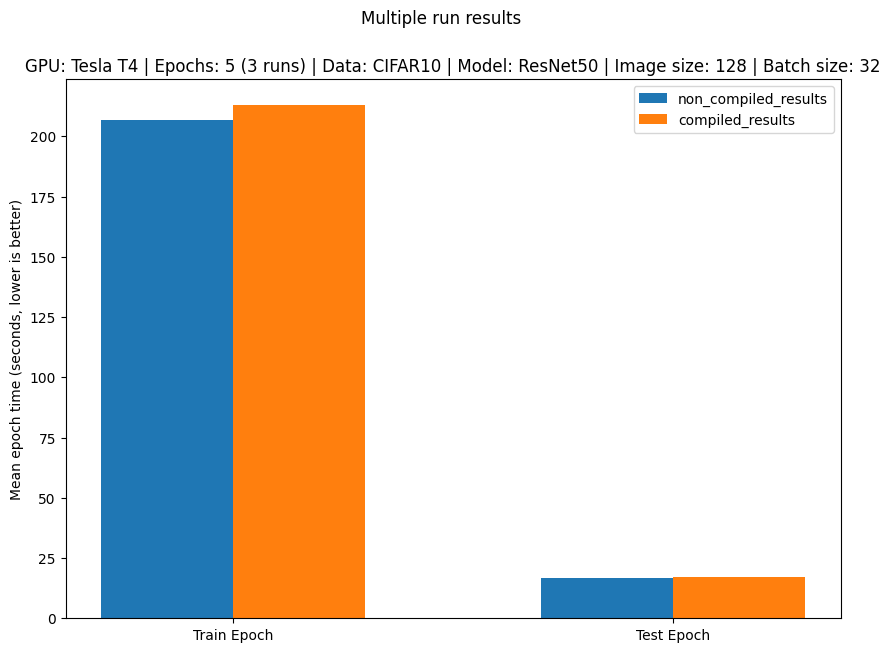

In [ ]:
# Create a directory to save the multi-run figure to
os.makedirs("pytorch_2_results/figures", exist_ok=True)

# Create a path to save the figure for multiple runs
save_path_multi_run = f"pytorch_2_results/figures/multi_run_{GPU_NAME}_{MODEL_NAME}_{DATASET_NAME}_{IMAGE_SIZE}_train_epoch_time.png"

# Plot the mean epoch times for experiment 3 and 4
plot_mean_epoch_times(non_compiled_results=non_compile_results_multiple_runs_df,
                      compiled_results=compile_results_multiple_runs_df,
                      multi_runs=True,
                      num_runs=NUM_RUNS,
                      save_path=save_path_multi_run,
                      save=True)

In [ ]:
# Make a directory for multi_run results
import os
pytorch_2_results_dir = "pytorch_2_results"
pytorch_2_multi_run_results_dir = f"{pytorch_2_results_dir}/multi_run_results"
os.makedirs(pytorch_2_multi_run_results_dir, exist_ok=True)

# Create filenames for each of the dataframes
save_name_for_multi_run_non_compiled_results = f"multi_run_non_compiled_results_{NUM_RUNS}_runs_{DATASET_NAME}_{MODEL_NAME}_{GPU_NAME}.csv"
save_name_for_multi_run_compiled_results = f"multi_run_compiled_results_{NUM_RUNS}_runs_{DATASET_NAME}_{MODEL_NAME}_{GPU_NAME}.csv"

# Create filepaths to save the results to
multi_run_no_compile_save_path = f"{pytorch_2_multi_run_results_dir}/{save_name_for_multi_run_non_compiled_results}"
multi_run_compile_save_path = f"{pytorch_2_multi_run_results_dir}/{save_name_for_multi_run_compiled_results}"
print(f"[INFO] Saving experiment 3 non-compiled results to: {multi_run_no_compile_save_path}")
print(f"[INFO] Saving experiment 4 compiled results to: {multi_run_compile_save_path}")

# Save the results
non_compile_results_multiple_runs_df.to_csv(multi_run_no_compile_save_path)
compile_results_multiple_runs_df.to_csv(multi_run_compile_save_path)

[INFO] Saving experiment 3 non-compiled results to: pytorch_2_results/multi_run_results/multi_run_non_compiled_results_3_runs_CIFAR10_ResNet50_Tesla_T4.csv
[INFO] Saving experiment 4 compiled results to: pytorch_2_results/multi_run_results/multi_run_compiled_results_3_runs_CIFAR10_ResNet50_Tesla_T4.csv
